<p><center> <img src="doc/header.png" width="1000"/> </p></center>

# LISFLOOD - a distributed hydrological rainfall-runoff model

LISFLOOD is a spatially distributed, semi-physical hydrological rainfall-runoff model that has been developed by the Joint Research Centre (JRC) of the European Commission in late 90ies. Since then LISFLOOD has been applied to a wide range of applications such as all kind of water resourses assessments looking at e.g. the effects of climate and land-use change as well as river regulation measures. Its most prominent application is probably within the [European Flood Awareness System](https://www.efas.eu/) (EFAS) operated under [Copernicus Emergency Management Service](https://emergency.copernicus.eu/) (EMS).

It’s wide applicability is due to its modular structure as well as its temporal and spatial flexibility. The model can be extended with additional modules when need arises, to satisfy the new target objective. In that sense it can be extended to include anything from a better representation of a particular hydrological flow to the implementation of anthropogenic-influenced processes. At the same time the model has been designed to be applied across a wide range of spatial and temporal scales. LISFLOOD is grid-based, and applications so far have employed grid cells of as little as 100 metres for medium-sized catchments, to 5000 metres for modelling the whole of Europe and up to 0.1° (around 10 km) for modelling globally. Long-term water balance can be simulated (using a daily time step), as well as individual flood events (using hourly time intervals, or even smaller).

Although LISFLOOD’s primary output product is channel discharge, all internal rate and state variables (soil moisture, for example) can be written as output as well. All output can be written as grids, or time series at user-defined points or areas. The user has complete control over how output is written, thus minimising any waste of disk space or CPU time.

Go to [Lisflood OS page](https://ec-jrc.github.io/lisflood/) for more information. Other useful resources:

| **Project** | **Documentation** | **Source code** |
| :--- | :--- | :--- |
| Lisflood | [Model docs](https://ec-jrc.github.io/lisflood-model/) | https://github.com/ec-jrc/lisflood-code (this repository) |
| | [User guide](https://ec-jrc.github.io/lisflood-code/) | |
| Lisvap | [Docs](https://ec-jrc.github.io/lisflood-lisvap/) | https://github.com/ec-jrc/lisflood-lisvap |
| Calibration tool | [Docs](https://ec-jrc.github.io/lisflood-calibration/) | https://github.com/ec-jrc/lisflood-calibration |
| Lisflood Utilities | | https://github.com/ec-jrc/lisflood-utilities |
| Lisflood Usecases | | https://github.com/ec-jrc/lisflood-usecases |


## Initialization

This section loads relevant Python modules for the following analysis.

In [2]:
# Click to EXPAND

#####################################################
###################### IMPORTS ######################
#####################################################

%matplotlib ipympl

import datetime
import xml.etree.ElementTree as ET

import altair as alt
import cartopy.crs as ccrs
import ipyleaflet
import ipywidgets
import pandas as pd
from ipyfilechooser import FileChooser
from matplotlib import rc

rc('animation', html='jshtml')
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import netCDF4
import cartopy.io.img_tiles as cimgt
import functools
import warnings
import subprocess

## Processing

After running the following code cell, please choose the respective settings files. Subsequently, a variety of input parameters such as the simulation period, calibration parameters, and output variables can be determined. If the discharge time series output is requested, an interactive map allows selecting the desired location. When all inputs are set, please click *'Start Processing'* to start the simulation. All settings are then updated in the settings files. The outputs are saved in a folder called *'out'*, which is automatically created at the level of the settings files.

In [ ]:
# Click to EXPAND

####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

# callback function to show settings after XML files are chosen
def show_settings(chooser):
    # checks whether PRE-RUN and RUN settings files are given
    if fc[0].selected != None and fc[1].selected != None:

        global tree
        global CalendarDayStart
        global DtSec_xml
        global DtSec_box
        global StepStart
        global StepStart_picker
        global StepEnd
        global StepEnd_picker
        global calibration_parameters_xml
        global calibration_sliders
        global optional_modules_xml
        global module_checkboxes
        global m
        global marker
        global coordinates
        
        # create output folder if it does not exist
        out_dir = os.path.join(fc[1].selected_path, "out")
        if not os.path.exists(out_dir): os.makedirs(out_dir, exist_ok=True)

        # opens settings file of PRE-RUN ([0]) and RUN ([1]) in list
        tree = [ET.parse(fc[0].selected), ET.parse(fc[1].selected)]
        # gets root of XML
        root = [tree[0].getroot(), tree[1].getroot()]

        # gets timestep and calendar day start from XML files
        DtSec_xml = [root[0].find("./lfuser/group/textvar[@name='DtSec']"),
                     root[1].find("./lfuser/group/textvar[@name='DtSec']")]
        # creates text box for timestep
        DtSec_box = ipywidgets.BoundedIntText(value=DtSec_xml[0].attrib['value'],
                                                 min=1,
                                                 max=31536000,
                                                 step=60,
                                                 description='Timestep [s]:',
                                                 layout=ipywidgets.Layout(width='40%'),
                                                 style={'description_width': '25ex'})
        date_str = root[1].find("./lfuser/group/textvar[@name='CalendarDayStart']").attrib['value'].split(' ')[0]
        time_str = root[1].find("./lfuser/group/textvar[@name='CalendarDayStart']").attrib['value'].split(' ')[1]
        CalendarDayStart = datetime.datetime(year=int(date_str.split('/')[2]),
                                             month=int(date_str.split('/')[1]),
                                             day=int(date_str.split('/')[0]),
                                             hour=int(time_str.split(':')[0]),
                                             minute=int(time_str.split(':')[1]))
        # finds simulation start date in XML files
        StepStart = [root[0].find("./lfuser/group/textvar[@name='StepStart']"),
                     root[1].find("./lfuser/group/textvar[@name='StepStart']")]
        # converts date format of StepStart
        StepStart_iso = [
            datetime.datetime.strptime(StepStart[0].attrib['value'].split()[0], "%d/%m/%Y").strftime("%Y-%m-%d"),
            datetime.datetime.strptime(StepStart[1].attrib['value'].split()[0], "%d/%m/%Y").strftime("%Y-%m-%d")]
        # creates date picker widgets with date set to XML input
        StepStart_picker = [ipywidgets.DatePicker(description='Pre Start Date',
                                                  value=datetime.date.fromisoformat(StepStart_iso[0]),
                                                  layout=ipywidgets.Layout(width='40%'),
                                                  style={'description_width': '25ex'}),
                            ipywidgets.DatePicker(description='Start Date',
                                                  value=datetime.date.fromisoformat(StepStart_iso[1]),
                                                  layout=ipywidgets.Layout(width='40%'),
                                                  style={'description_width': '25ex'})]
        # finds simulation end date in XML files
        StepEnd = [root[0].find("./lfuser/group/textvar[@name='StepEnd']"),
                   root[1].find("./lfuser/group/textvar[@name='StepEnd']")]
        # converts date format of StepEnd
        StepEnd_iso = [
            datetime.datetime.strptime(StepEnd[0].attrib['value'].split()[0], "%d/%m/%Y").strftime("%Y-%m-%d"),
            datetime.datetime.strptime(StepEnd[1].attrib['value'].split()[0], "%d/%m/%Y").strftime("%Y-%m-%d")]
        # creates date picker widgets with date set to XML input
        StepEnd_picker = [ipywidgets.DatePicker(description='Pre Stop Date',
                                                value=datetime.date.fromisoformat(StepEnd_iso[0]),
                                                layout=ipywidgets.Layout(width='40%'),
                                                style={'description_width': '25ex'}),
                          ipywidgets.DatePicker(description='Stop Date',
                                                value=datetime.date.fromisoformat(StepEnd_iso[1]),
                                                layout=ipywidgets.Layout(width='40%'),
                                                style={'description_width': '25ex'})]


        # creates empty list for slider widgets
        calibration_sliders = {}
        # finds calibration parameter group in XML files
        calibration_parameters_xml = [root[0].find("./lfuser")[2], root[1].find("./lfuser")[2]]
        # loops through calibration parameters listed in RUN settings file
        for element in calibration_parameters_xml[1]:
            # checks element type in XML file and allowed data range in parameter_specs dictionary
            if (element.tag == 'textvar' and element.attrib['name'] in parameter_specs):
                # creates slider widgets and appends to slider list
                calibration_sliders[element.attrib['name']] = ipywidgets.HBox([
                    ipywidgets.FloatSlider(value=element.attrib['value'],
                                                 min=parameter_specs[element.attrib['name']][0],
                                                 max=parameter_specs[element.attrib['name']][1],
                                                 step=parameter_specs[element.attrib['name']][2],
                                                 description=element.attrib['name'],
                                                 disabled=False,
                                                 continuous_update=False,
                                                 orientation='horizontal',
                                                 readout=True,
                                                 readout_format=parameter_specs[element.attrib['name']][3],
                                                 layout=ipywidgets.Layout(width='80%'),
                                                 style={'description_width': '25ex'}),
                    #ipywidgets.Label(value=parameter_specs[element.attrib['name']][4])])
                    ipywidgets.HTML(value=parameter_specs[element.attrib['name']][4])])

        # creates empty list for checkbox widgets
        module_checkboxes = {}
        # finds optional modules group in XML files
        optional_modules_xml = [root[0].find("./lfoptions"), root[1].find("./lfoptions")]
        # loops through optional modules listed in RUN settings file
        for element in optional_modules_xml[1]:
            # creates checkbox widgets and appends to checkbox list
            module_checkboxes[element.attrib['name']] = ipywidgets.Checkbox(
                value=bool(int(element.attrib['choice'])),
                description=element.attrib['name'],
                disabled=False,
                style={'description_width': '0ex'})

        # reads coordinates from XML RUN file
        coordinates = [root[0].findall("./lfuser/group/textvar/[@name='Gauges']")[0],
                       root[1].findall("./lfuser/group/textvar/[@name='Gauges']")[0]]
        lon, lat = coordinates[1].attrib['value'].split()
        center = (lat, lon)
        # creates interactive map with draggable marker
        m = ipyleaflet.Map(zoom=10, center=center, scroll_wheel_zoom=True)
        marker = ipyleaflet.Marker(location=center, draggable=True)
        m.add_layer(marker)
        # initializes visibility of map
        if module_checkboxes['repDischargeTs'].value == True:
            m.layout.display = "block"
        else:
            m.layout.display = "none"

        # # creates tab widget
        # tabs = ipywidgets.Tab()
        # # sets tab titles
        # tabs.set_title(0, 'Outputs')
        # tabs.set_title(1, 'Date Selection')
        # tabs.set_title(2, 'Calibration')
        # tabs.set_title(3, 'Optional Modules')

        output_grid = ipywidgets.GridspecLayout(13, 3, height='auto')
        output_grid[0:8, 0] = ipywidgets.VBox([ipywidgets.HTML(value='<b>Surface Water Outputs:</b>'),
                                               module_checkboxes['repDischargeMaps'],
                                               module_checkboxes['repDischargeTs'],
                                               module_checkboxes['repsimulateReservoirs'],
                                               module_checkboxes['repsimulateLakes'],
                                               module_checkboxes['repSnowCoverMaps'],
                                               module_checkboxes['repSnowMeltMaps'],
                                               module_checkboxes['repSurfaceRunoffMaps']])
        output_grid[0:9, 1] = ipywidgets.VBox([ipywidgets.HTML(value='<b>Soil Outputs:</b>'),
                                               module_checkboxes['repThetaMaps'],
                                               module_checkboxes['repThetaForestMaps'],
                                               module_checkboxes['repThetaIrrigationMaps']])
        output_grid[0:9, 2] = ipywidgets.VBox([ipywidgets.HTML(value='<b>Groundwater Outputs:</b>'),
                                               module_checkboxes['repPFMaps'],
                                               module_checkboxes['repPFForestMaps'],
                                               module_checkboxes['repUZMaps'],
                                               module_checkboxes['repLZMaps']])
        output_grid[9:13, 0] = ipywidgets.VBox([ipywidgets.HTML(value='<b>Water Use Outputs:</b>'),
                                                module_checkboxes['repTotalAbs'],
                                                module_checkboxes['repTotalWUse']])
        output_grid[9:13, 1] = ipywidgets.VBox([ipywidgets.HTML(value='<b>State and End Maps:</b>'),
                                                module_checkboxes['repStateMaps'],
                                                module_checkboxes['repEndMaps']])

        # adds content to tabs
        # tabs = ipywidgets.Tab(children=[
        #         ipywidgets.VBox([output_grid, m]),
        #         ipywidgets.VBox(
        #             [StepStart_picker[0], StepEnd_picker[0],
        #             StepStart_picker[1], StepEnd_picker[1],
        #             DtSec_box]),
        #         ipywidgets.VBox(list(calibration_sliders.values())),
        #         ipywidgets.VBox([
        #             ipywidgets.GridBox(
        #                 [
        #                     module_checkboxes['InitLisflood'],
        #                     module_checkboxes['InitLisfloodwithoutSplit'],
        #                     module_checkboxes['gridSizeUserDefined'],
        #                     module_checkboxes['SplitRouting'],
        #                     module_checkboxes['inflow'],
        #                     module_checkboxes['simulateReservoirs'],
        #                     module_checkboxes['simulateLakes'],
        #                     module_checkboxes['openwaterevapo'],
        #                     module_checkboxes['drainedIrrigation'],
        #                     module_checkboxes['riceIrrigation'],
        #                     module_checkboxes['wateruse'],
        #                     module_checkboxes['useWaterDemandAveYear'],
        #                     module_checkboxes['TransientWaterDemandChange'],
        #                     module_checkboxes['wateruseRegion'],
        #                     module_checkboxes['groundwaterSmooth'],
        #                     module_checkboxes['indicator'],
        #                     module_checkboxes['readNetcdfStack'],
        #                     module_checkboxes['writeNetcdf'],
        #                     module_checkboxes['writeNetcdfStack'],
        #                 ],
        #                 layout=ipywidgets.Layout(grid_template_columns="33% 33% 33%")
        #             )
        #         ])
        #     ])
        # 1️⃣ create tab widget
        tabs = ipywidgets.Tab()

        # 2️⃣ add children (this creates the tabs)
        tabs.children = [
            ipywidgets.VBox([output_grid, m]),
            ipywidgets.VBox(
                [StepStart_picker[0], StepEnd_picker[0],
                StepStart_picker[1], StepEnd_picker[1],
                DtSec_box]),
            ipywidgets.VBox(list(calibration_sliders.values())),
            ipywidgets.VBox([
                ipywidgets.GridBox(
                    [
                        module_checkboxes['InitLisflood'],
                        module_checkboxes['InitLisfloodwithoutSplit'],
                        module_checkboxes['gridSizeUserDefined'],
                        module_checkboxes['SplitRouting'],
                        module_checkboxes['inflow'],
                        module_checkboxes['simulateReservoirs'],
                        module_checkboxes['simulateLakes'],
                        module_checkboxes['openwaterevapo'],
                        module_checkboxes['drainedIrrigation'],
                        module_checkboxes['riceIrrigation'],
                        module_checkboxes['wateruse'],
                        module_checkboxes['useWaterDemandAveYear'],
                        module_checkboxes['TransientWaterDemandChange'],
                        module_checkboxes['wateruseRegion'],
                        module_checkboxes['groundwaterSmooth'],
                        module_checkboxes['indicator'],
                        module_checkboxes['readNetcdfStack'],
                        module_checkboxes['writeNetcdf'],
                        module_checkboxes['writeNetcdfStack'],
                    ],
                    layout=ipywidgets.Layout(grid_template_columns="33% 33% 33%")
                )
            ])
        ]

        # 3️⃣ now titles are valid
        tabs.set_title(0, 'Outputs')
        tabs.set_title(1, 'Date Selection')
        tabs.set_title(2, 'Calibration')
        tabs.set_title(3, 'Optional Modules')

        if module_checkboxes['SplitRouting'].value == True:
            module_checkboxes['InitLisflood'].value = True
            module_checkboxes['InitLisfloodwithoutSplit'].value = False
            module_checkboxes['InitLisfloodwithoutSplit'].disabled = True
        else:
            module_checkboxes['InitLisflood'].value = False
            module_checkboxes['InitLisflood'].disabled = True
            module_checkboxes['InitLisfloodwithoutSplit'].value = True

        module_checkboxes['SplitRouting'].observe(on_SplitRouting_clicked, names='value')
        module_checkboxes['repDischargeTs'].observe(on_repDischargeTs_clicked, names='value')

        # display options
        display(tabs)

        # button to start processing method
        processingButton = ipywidgets.Button(description="Start processing")
        processingButton.on_click(on_processingButton_clicked)
        display(processingButton)


# callback function to write input data to XML files and start processing of PRE-RUN and RUN
def on_processingButton_clicked(b):    
    # checks whether variable 'datasets' with reference to NetCDF files exists
    # if yes, closes all NetCDF files to re-write them
    # if no, creates empty list 'datasets'
    if 'datasets' in locals():
        for item in datasets:
            item[1].close()
        datasets.clear()
    else:
        datasets = []

    # loops through references to PRE-RUN and RUN settings files
    for calibration_list in calibration_parameters_xml:
        # loops through calibration parameters listed in RUN settings file
        for element in calibration_list:
            # checks element type in XML file and allowed data range in parameter_specs dictionary
            if (element.tag == 'textvar' and element.attrib['name'] in parameter_specs):
                # updates value based on user input section
                element.attrib['value'] = str(calibration_sliders[element.attrib['name']].children[0].value)

    # loops through references to PRE-RUN and RUN settings files
    for module_list in optional_modules_xml:
        # loops through calibration parameters listed in RUN settings file
        for element in module_list:
            # updates value based on user input section
            #print('\nVorher ', element.attrib['choice'], '\nNachher', str(int(module_checkboxes[element.attrib['name']].value)), element.attrib)
            element.attrib['choice'] = str(int(module_checkboxes[element.attrib['name']].value))

    # sets allowed combinations for SplitRouting
    if module_checkboxes['SplitRouting'].value:
        optional_modules_xml[0].findall("setoption[@name='SplitRouting']")[0].attrib['choice'] = '1'
        optional_modules_xml[0].findall("setoption[@name='InitLisflood']")[0].attrib['choice'] = '1'
        optional_modules_xml[0].findall("setoption[@name='InitLisfloodwithoutSplit']")[0].attrib['choice'] = '0'
        optional_modules_xml[1].findall("setoption[@name='SplitRouting']")[0].attrib['choice'] = '1'
        optional_modules_xml[1].findall("setoption[@name='InitLisflood']")[0].attrib['choice'] = '0'
        optional_modules_xml[1].findall("setoption[@name='InitLisfloodwithoutSplit']")[0].attrib['choice'] = '0'
    else:
        optional_modules_xml[0].findall("setoption[@name='SplitRouting']")[0].attrib['choice'] = '0'
        optional_modules_xml[0].findall("setoption[@name='InitLisflood']")[0].attrib['choice'] = '0'
        optional_modules_xml[0].findall("setoption[@name='InitLisfloodwithoutSplit']")[0].attrib['choice'] = '1'
        optional_modules_xml[1].findall("setoption[@name='SplitRouting']")[0].attrib['choice'] = '0'
        optional_modules_xml[1].findall("setoption[@name='InitLisflood']")[0].attrib['choice'] = '0'
        optional_modules_xml[1].findall("setoption[@name='InitLisfloodwithoutSplit']")[0].attrib['choice'] = '0'

    # writes simulation start and stop date, timestep and coordinates from user input section to both settings files
    for i in range(len(tree)):
        StepStart[i].attrib['value'] = '%s %s' % (
        str(datetime.datetime.strptime(str(StepStart_picker[i].value), "%Y-%m-%d").strftime("%d/%m/%Y")),
        StepStart[i].attrib['value'].split()[1])
        StepEnd[i].attrib['value'] = '%s %s' % (
        str(datetime.datetime.strptime(str(StepEnd_picker[i].value), "%Y-%m-%d").strftime("%d/%m/%Y")),
        StepEnd[i].attrib['value'].split()[1])
        DtSec_xml[i].attrib['value'] = str(DtSec_box.value)
        if module_checkboxes['repDischargeTs'].value == True: 
            coordinates[i].attrib['value'] = '{} {}'.format(marker.location[1], marker.location[0])
        tree[i].write(fc[i].selected)

    # starts LISFLOOD PRE-RUN and RUN according to (new) input
    path1 = fc[0].selected
    path2 = fc[1].selected
    print('PRE-RUN...\n')
    !lisflood $path1
    print('\n\n\n\nRUN...\n')
    !lisflood $path2
    print("\nDone")


# callback function to change map visibility
def on_repDischargeTs_clicked(button):
    if button['new']:
        m.layout.display = "block"
    else:
        m.layout.display = "none"


# callback function to prevent false input regarding SplitRouting
def on_SplitRouting_clicked(button):
    if button['new']:
        module_checkboxes['InitLisflood'].disabled = False
        module_checkboxes['InitLisfloodwithoutSplit'].value = False
        module_checkboxes['InitLisfloodwithoutSplit'].disabled = True
    else:
        module_checkboxes['InitLisflood'].value = False
        module_checkboxes['InitLisflood'].disabled = True
        module_checkboxes['InitLisfloodwithoutSplit'].disabled = False


####################################################
####################### CODE #######################
####################################################

# dictionary which contains editable calibration parameters including allowed data range
# parameter_specs = {
#     # parameter name           min   max    step  format  unit
#     "UpperZoneTimeConstant": [0.01, 40, 0.01, '.2f', r'\(\left[\text{days}\right]\)'],
#     "LowerZoneTimeConstant": [1000, 10500, 5, '.0f', r'\(\left[\text{days}\right]\)'],
#     "GwPercValue": [0.01, 2, 0.01, '.2f', r'\(\left[-\right]\)'],
#     "GwLoss": [0, 0.5, 0.01, '.2f', r'\(\frac{\text{mm}}{\text{day}}\)'],
#     "b_Xinanjiang": [0.5, 5, 0.01, '.2f', r'\(\left[-\right]\)'],
#     "PowerPrefFlow": [0.5, 8, 0.01, '.2f', r'\(\left[-\right]\)'],
#     "CalChanMan": [0.1, 20, 0.01, '.2f', r'\(\left[-\right]\)'],
#     "SnowMeltCoef": [2.5, 6.5, 0.01, '.2f', r'\(\frac{\text{mm}}{\text{C day}}\)'],
#     "CalChanMan2": [0.1, 20, 0.01, '.2f', r'\(\left[-\right]\)'],
# }

parameter_specs = {
    # parameter name           min   max    step  format  unit
    "UpperZoneTimeConstant": [0.01, 40, 0.01, '.2f', "[days]"],
    "LowerZoneTimeConstant": [1000, 10500, 5, '.0f', "[days]"],
    "GwPercValue": [0.01, 2, 0.01, '.2f', "[-]"],
    "GwLoss": [0, 0.5, 0.01, '.2f', "mm/day"],
    "b_Xinanjiang": [0.5, 5, 0.01, '.2f', "[-]"],
    "PowerPrefFlow": [0.5, 8, 0.01, '.2f', "[-]"],
    "CalChanMan": [0.1, 20, 0.01, '.2f', "[-]"],
    "SnowMeltCoef": [2.5, 6.5, 0.01, '.2f', "mm/(C·day)"],
    "CalChanMan2": [0.1, 20, 0.01, '.2f', "[-]"],
}

# creates list of file choosers for PRE-RUN and RUN settings file
fc = [FileChooser(os.getcwd()), FileChooser(os.getcwd())]
# sets title of file chooser
fc[0].title = '<b>Please select PRE-RUN Settings File:</b>'
fc[1].title = '<b>Please select RUN Settings File:</b>'
# initializes file chooser
for chooser in fc:
    # only show XML files and folders
    chooser.filter_pattern = '*.xml'
    # uses icon for folder to easier distinguish between folders and files
    chooser.use_dir_icons = True
    # callback function for RUN XML file
    chooser.register_callback(show_settings)
# display file chooser
ipywidgets.VBox([fc[0], fc[1]])

Button(description='Start processing', style=ButtonStyle())

## Outputs

Please run the code cell below to visualize the outputs. The notebook can also be used to visualize data of previous LISFLOOD runs. When running the [Outputs](#Outputs) code cell, the notebook checks whether the [Processing](#Processing) code cell has been executed before. If yes, it opens the output files coming from this LISFLOOD run. If not, it opens another file chooser where you can choose the output folder that you would like to visualize. 

FileChooser(path='/storage/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usec…

HTML(value='<center><b><font size=5>Discharge Time Series</b></center>')

alt.Chart(...)

HTML(value='<center><b><font size=5>Spatial Outputs</b></center>')

Output()

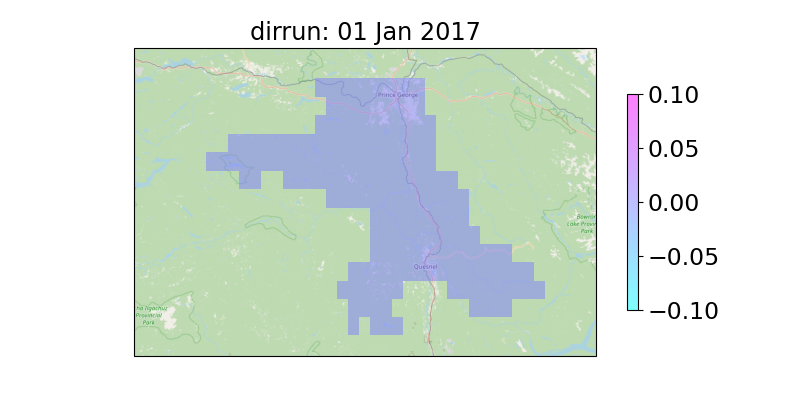

In [4]:
# Click to EXPAND

# returns element in NetCDF array
def subfinder(mylist, parameter):
    for i in range(len(mylist)):
        if mylist[i][0] == parameter:
            match = mylist[i][1]
    return match


# updates date of spatial plot from time slider
def update_time(date):
    mm.set_array(subfinder(datasets, parameter_dropdown.value)[parameter_dropdown.value][:][date].ravel())
    title = '{}: {}'.format(parameter_dropdown.value, datevar[0][date].strftime('%d %b %Y'))
    plt.title(title, size='xx-large')
    plt.draw()


#  updates parameter of spatial plot from dropdown menu
def update_parameter(parameter):
    mm.set_array(subfinder(datasets, parameter)[parameter][:][date_slider.value].ravel())
    mm.autoscale()
    cbar.update_normal(mm)
    title = '{}: {}'.format(parameter, datevar[0][date_slider.value].strftime('%d %b %Y'))
    plt.title(title, size='xx-large')
    plt.draw()


# adds CSV data to time series data frame
def addData(df, path, setting):
    df_temp = pd.read_csv(path, delim_whitespace=True, header=None)
    df_temp = df_temp.drop([0, 1, 2, 3], axis=0)
    df_temp = df_temp.drop([2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    df_temp.columns = ['date', 'value']
    df_temp.insert(0, 'setting', [setting] * len(df_temp.index), True)

    return pd.concat([df, df_temp], axis=0, ignore_index=True)


# plots spatial and time series output data
def plot(chooser, output_dir):
    # sets path to output directory depending on function parameters
    if output_dir:
        path = chooser.selected_path
    else:
        path = os.path.join(chooser.selected_path, 'out')

    # checks whether output data is present
    if len(glob.glob('{}/*.nc'.format(path))) == 0 and len(glob.glob('{}/*.tss'.format(path))) == 0:
        print('No output files in {}.'.format(path))

    global datevar
    
    # checks for 'dis_run.tss' file
    if os.path.isfile('{}/dis_run.tss'.format(path)):
        # creates data frame and reads 'dis_run.tss'
        df = pd.DataFrame()
        df = addData(df, '{}/dis_run.tss'.format(path), 'Discharge')
        # if output was generated using the processing section of this notebook,
        # the calendar start day can be read from the XML file
        if 'CalendarDayStart' in globals():
            dates = []
            DtSec = datetime.timedelta(seconds=int(DtSec_xml[1].attrib['value']))
            for factor in df['date']:
                dates.append(CalendarDayStart + (int(factor) - 1) * DtSec)
            df['date'] = dates
        elif 'datevar' in globals():
            df['date'] = datevar[0].tolist()
        # if not, x-axis can not be reformated
        else:
            print('No reference data on CalendarDayStart to format x-axis of time series plot.')
        # plots data
        selection = alt.selection_multi(fields=['setting'], bind='legend')
        chart = alt.Chart(df
                ).mark_line(point=True
                ).encode(x='date:T',
                         y='value:Q',
                         color=alt.Color('setting', legend=alt.Legend(title="Setting")),
                         opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
                ).add_selection(selection
                ).interactive(bind_y=False
                ).properties(width=800, height=300)
        # display outputs
        display(ipywidgets.HTML(value = f"<center><b><font size=5>{'Discharge Time Series'}</b></center>"))
        display(chart)

    # check for spatial output files in output folder
    if len(glob.glob('{}/*.nc'.format(path))) != 0:

        global datasets
        global date_slider
        global parameter_dropdown
        global mm
        global cbar

        # list of paths to  all spatial output files except avgdis and lzavin
        paths_datasets = list(filter(lambda number: (not number.endswith('avgdis.nc') and not number.endswith('lzavin.nc')),
                                     glob.glob('{}/*.nc'.format(path))))
        
        if 'datasets' in locals():
            datasets.clear()
        else:
            datasets = []

        i = 0
        # open netCDF datasets
        for dataset in paths_datasets:
            datasets.append([dataset.split('/')[-1].split('.')[0], netCDF4.Dataset(paths_datasets[i])])
            i = i + 1

        # get dates from NetCDF file
        try:
            # get calendar
            t_cal = datasets[0][1].variables['time'].calendar
        except AttributeError:
            t_cal = u"gregorian"
        datevar = []
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            datevar.append(netCDF4.num2date(datasets[0][1].variables['time'][:],  # get values
                                        units=datasets[0][1].variables['time'].units,  # get unit
                                        calendar=t_cal))

        # create drowdown menu with all available outputs
        parameter_dropdown = ipywidgets.Dropdown(options=[item[0] for item in datasets], description='Parameter:')
        # create date slider for given time period
        date_slider = ipywidgets.IntSlider(min=0, max=len(datasets[0][1].dimensions['time']) - 1, step=1, value=0,
                                           description='Date:')
        # create simulation controls
        play = ipywidgets.Play(
            min=0,
            max=len(datasets[0][1].dimensions['time']) - 1,
            step=1,
            description="Press play",
            disabled=False
        )

        # get chosen parameter
        parameter = parameter_dropdown.value
        # create figure
        out_spatial = ipywidgets.Output()
        with out_spatial:
            # create figure with open street map
            request = cimgt.OSM()
            fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=request.crs))
            ax.add_image(request, 8)
            cmap = plt.cm.cool
            vmin = np.min(subfinder(datasets, parameter)[parameter][:])
            vmax = np.max(subfinder(datasets, parameter)[parameter][:])
            #vmax = np.percentile(subfinder(datasets, parameter)[parameter][:], 97.5)
            mm = ax.pcolormesh(subfinder(datasets, parameter)['lon'][:],
                               subfinder(datasets, parameter)['lat'][:],
                               subfinder(datasets, parameter)[parameter][:][0],
                               vmin=vmin,
                               vmax=vmax,
                               transform=ccrs.PlateCarree(),
                               cmap=cmap,
                               alpha=0.5)
            cbar = plt.colorbar(mm, shrink=0.7)
            cbar.ax.tick_params(labelsize=17)
            update_time(0)
            
        # update plot when user changes parameter in dropdown menu
        ipywidgets.interactive(update_parameter, parameter=parameter_dropdown)
        # update plot when user changes date slider
        ipywidgets.interactive(update_time, date=date_slider)
        # update plot when user starts simulation
        ipywidgets.jslink((play, 'value'), (date_slider, 'value'))

        # display outputs
        display(ipywidgets.HTML(value = f"<center><b><font size=5>{'Spatial Outputs'}</b></center>"))
        display(out_spatial)
        display(ipywidgets.HBox([play, date_slider, parameter_dropdown]))
        print('\n\n\n\n\n\n\n\n')
        

####################################################
####################### CODE #######################
####################################################

# check if filechooser exist from processing
if 'fc' in locals():
    plot(fc[1], output_dir=False)
# if not show file chooser
else:
    # create file chooser for output folder
    chooser = FileChooser(os.getcwd())
    # sets title of file chooser
    chooser.title = '<b>Please select output folder:</b>'
    # only show folders
    chooser.show_only_dirs = True
    # show directory icons
    chooser.use_dir_icons = True
    # callback function
    chooser.register_callback(functools.partial(plot, output_dir=True))
    # display file chooser
    display(chooser)